In [ ]:
import os
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
from itertools import chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pretrained_vgg = models.vgg16_bn(pretrained=True)
DATA_MODES = ['train', 'val', 'test']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


device(type='cuda')

In [ ]:
class My_Detector(nn.Module):
    def __init__(self, n_classes=1, n_coords=4):
        super(My_Detector, self).__init__()

        self.backbone = pretrained_vgg.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.neck = pretrained_vgg.classifier[:6]
        
        self.head_classifier = nn.Linear(4096, n_classes)
        self.head_coords_regressors = nn.Linear(4096, n_coords)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.neck(x)
        label = self.head_classifier(x) 
        bbox = self.head_coords_regressors(x)
        return label, bbox

In [ ]:
class MultiTaskLoss(nn.Module):
    def __init__(self, weight=None, alpha=25):
        super(MultiTaskLoss, self).__init__()

        self.classifier_loss = nn.CrossEntropyLoss(weight)
        self.regressor_loss = nn.MSELoss()
        self.alpha = alpha #Будем как можно сильнее штрафовать модель за ее регрессионную компоненту, 
                           #чтобы она училась как можно точнее предсказывать все 4 координаты


    def forward(self, input, target, input_bboxes, target_bboxes):
        clf_loss = self.classifier_loss(input, target)
        reg_loss = self.regressor_loss(input_bboxes, target_bboxes)
        return clf_loss + self.alpha*reg_loss

In [ ]:
class GTSRB_Dataset(Dataset):
    def __init__(self, root, files, mode):
        super().__init__()
        self.files = np.array(files).astype(str).tolist()
        self.mode = mode
        if self.mode not in DATA_MODES:
            raise NameError(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
        self.len_ = len(self.files)
        data = pd.read_csv(os.path.join(root, 'Train.csv')) \
               if self.mode != 'test' else  pd.read_csv(os.path.join(root, 'Test.csv'))
        data.Path = data.Path.apply(lambda path: os.path.join(root, path))
        data = data.set_index('Path').loc[self.files]
        self.labels = data.ClassId
        scales = data.iloc[:, :2]
        scales = scales.merge(scales, on='Path').values
        self.bboxes = data.iloc[:, 2:6] / scales
                      
    def __len__(self):
        return self.len_
  
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((32, 32)),
                                        transforms.RandomApply([transforms.Lambda(lambda x : x + torch.randn_like(x) / 25)]),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])]) if self.mode == 'train' else \
                    transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((32, 32)),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])
                    
        image = self.files[index]
        label = self.labels[image]
        bbox = torch.FloatTensor(self.bboxes.loc[image])
        image = transform(Image.open(image))
        return image, label, bbox

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, device, sched=None):
    model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb, bboxes in tqdm(train_dl):
            xb, yb, bboxes = xb.to(device), yb.to(device), bboxes.to(device)
            y_pred,  pred_bboxes = model(xb)
            loss = loss_func(y_pred, yb, pred_bboxes, bboxes)
            loss_sum += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        with torch.no_grad():
            for xb, yb, bboxes in valid_dl:
                xb, yb, bboxes = xb.to(device), yb.to(device), bboxes.to(device)
                y_pred,  pred_bboxes = model(xb)
                loss = loss_func(y_pred, yb, pred_bboxes, bboxes)
                loss_sum += loss.item()  
        val_losses.append(loss_sum / len(valid_dl))
        
        if sched is not None:
            sched.step()

        print(f'epoch {epoch + 1}:')
        print(f'train loss = {train_losses[epoch]:.5f} | valid loss = {val_losses[epoch]:.5f}', '\n')

    return train_losses, val_losses

In [ ]:
def plot_trainig(train_losses, valid_losses):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(16, 6))
    plt.xlabel('epoch')
    plt.plot(epochs, train_losses, label='train_loss')
    plt.plot(epochs, valid_losses, label='valid_loss')
    plt.legend()
    plt.grid(True)

In [ ]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[0]
            logits.append(outputs.cpu())
            
    preds = torch.cat(logits)
    return preds.softmax(-1).detach().numpy().argmax(1)

In [ ]:
def predict_proba(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[0]
            logits.append(outputs.cpu())
            
    preds = torch.cat(logits)
    return preds.softmax(-1).detach().numpy().max(1)

In [ ]:
def predict_bbox(model, loader):
    with torch.no_grad():
        logits = []
    
        for inputs, label, bbox in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs)[1]
            logits.append(outputs.cpu())
            
    bboxes = torch.cat(logits)
    return bboxes.detach().numpy()

In [ ]:
def calculate_IoU(bboxA, bboxB):
    xA = max(bboxA[0], bboxB[0])
    yA = max(bboxA[1], bboxB[1])
    xB = min(bboxA[2], bboxB[2])
    yB = min(bboxA[3], bboxB[3])
    interArea = abs(max(0, xB - xA) * max(0, yB - yA))
    bboxAArea = abs((bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1]))
    bboxBArea = abs((bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1]))
    iou = interArea / (bboxAArea + bboxBArea - interArea)
    return iou

In [ ]:
def imshow(input_tensor, title, bbox, pred=None, plt_ax=plt):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    scale = 32
    image = input_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    image = np.clip(image, 0, 1)
    xmin, ymin, xmax, ymax = bbox * scale
    plt_ax.imshow(image)
    plt_ax.set_title(title)
    plt_ax.axis('off')
    plt_ax.hlines(ymin, xmin, xmax, colors='aqua', label='True')
    plt_ax.hlines(ymax, xmin, xmax, colors='aqua')
    plt_ax.vlines(xmin, ymin, ymax, colors='aqua')
    plt_ax.vlines(xmax, ymin, ymax, colors='aqua')
    if pred is not None:
        pred_title, pred_bbox, proba, IoU = pred
        pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox * scale
        plt_ax.hlines(pred_ymin, pred_xmin, pred_xmax, colors='lime', label='Predicted')
        plt_ax.hlines(pred_ymax, pred_xmin, pred_xmax, colors='lime')
        plt_ax.vlines(pred_xmin, pred_ymin, pred_ymax, colors='lime')
        plt_ax.vlines(pred_xmax, pred_ymin, pred_ymax, colors='lime')
        box = {'facecolor':'gray',   'alpha' : 0.3}
        plt_ax.text(pred_xmin, pred_ymin, pred_title + f' {proba * 100 :.0f}% IoU = {IoU * 100 :.0f}%', bbox=box)
        plt_ax.legend(loc='lower right')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/GTSRB\ dataset/GTSRB.zip

In [ ]:
TRAIN_DIR = Path('GTSRB/Train')
TEST_DIR = Path('GTSRB/Test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, 
                                          stratify=train_val_labels, random_state=42)

In [ ]:
torch.manual_seed(123)
data_dir = 'GTSRB'

train_dataset = GTSRB_Dataset(data_dir, train_files, mode="train")
val_dataset = GTSRB_Dataset(data_dir, val_files, mode="val")
test_dataset = GTSRB_Dataset(data_dir, test_files, mode="test")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

classes = pd.read_csv('GTSRB/signnames.csv').SignName.values
n_classes = len(classes)

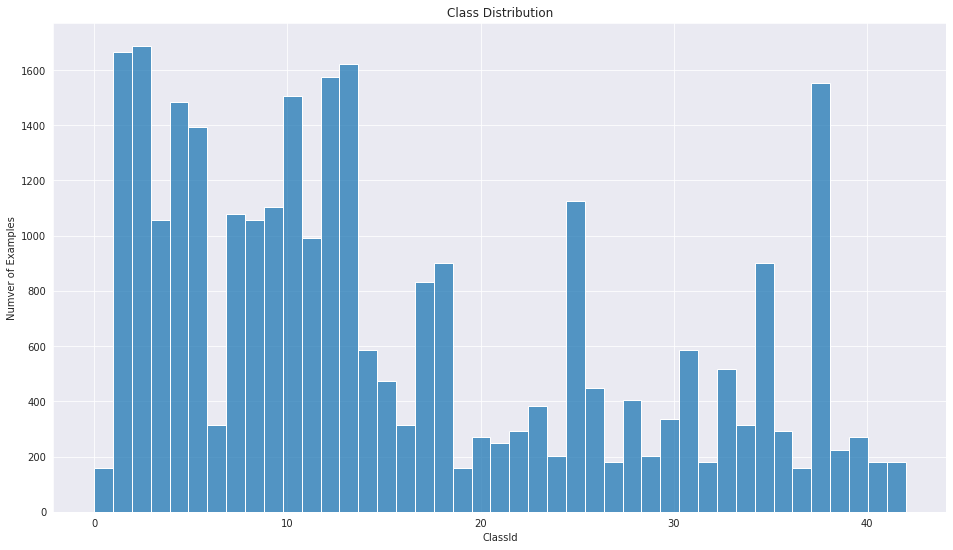

In [ ]:
train_labels = train_dataset.labels

plt.figure(figsize=(16, 9))
sns.set_style("darkgrid")
sns.histplot(data=train_labels, bins=n_classes)
plt.title('Сlass Distribution')
plt.ylabel('Numver of Examples')
plt.show()

In [ ]:
weight = torch.FloatTensor(compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)).to(DEVICE)

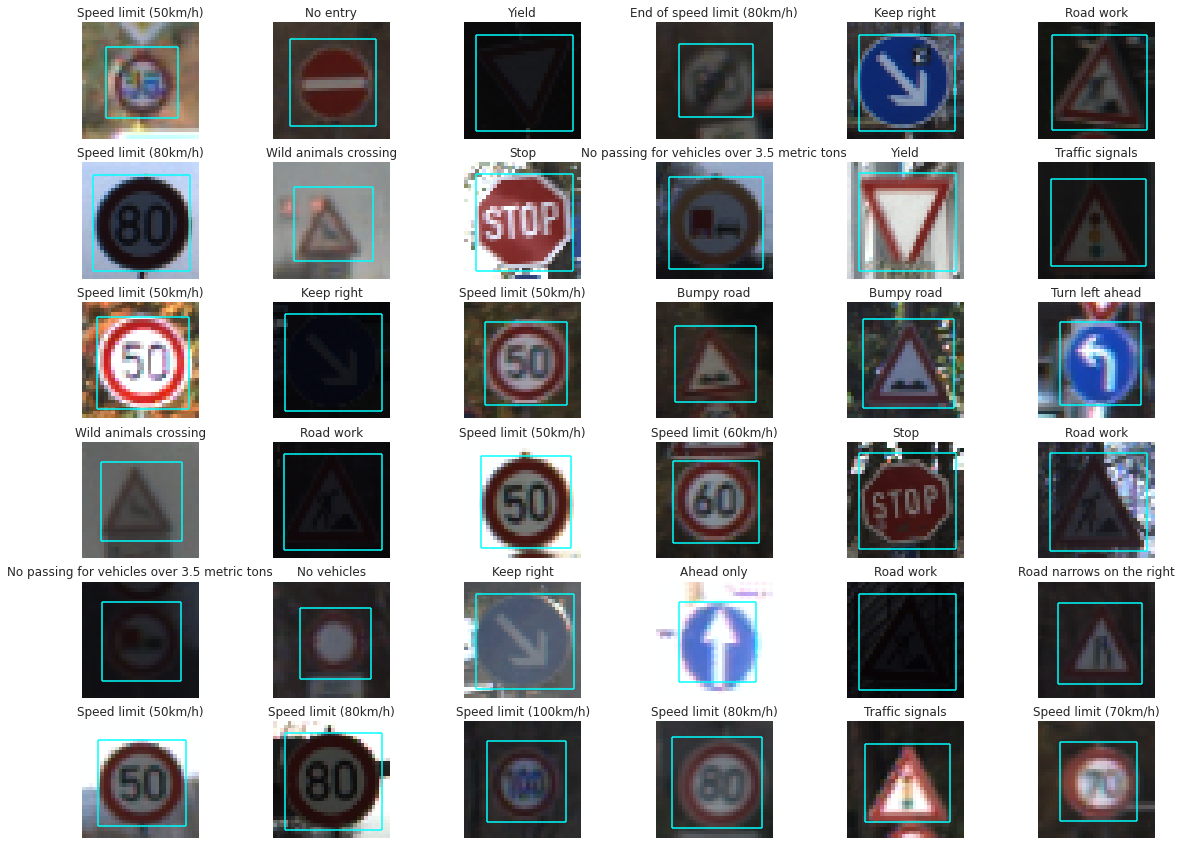

In [ ]:
np.random.seed(13)

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20, 15), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_sign = np.random.randint(0, len(val_dataset))
    img_val, label, bbox = val_dataset[random_sign]
    img_label = classes[label]
    imshow(img_val, img_label, bbox, plt_ax=fig_x)

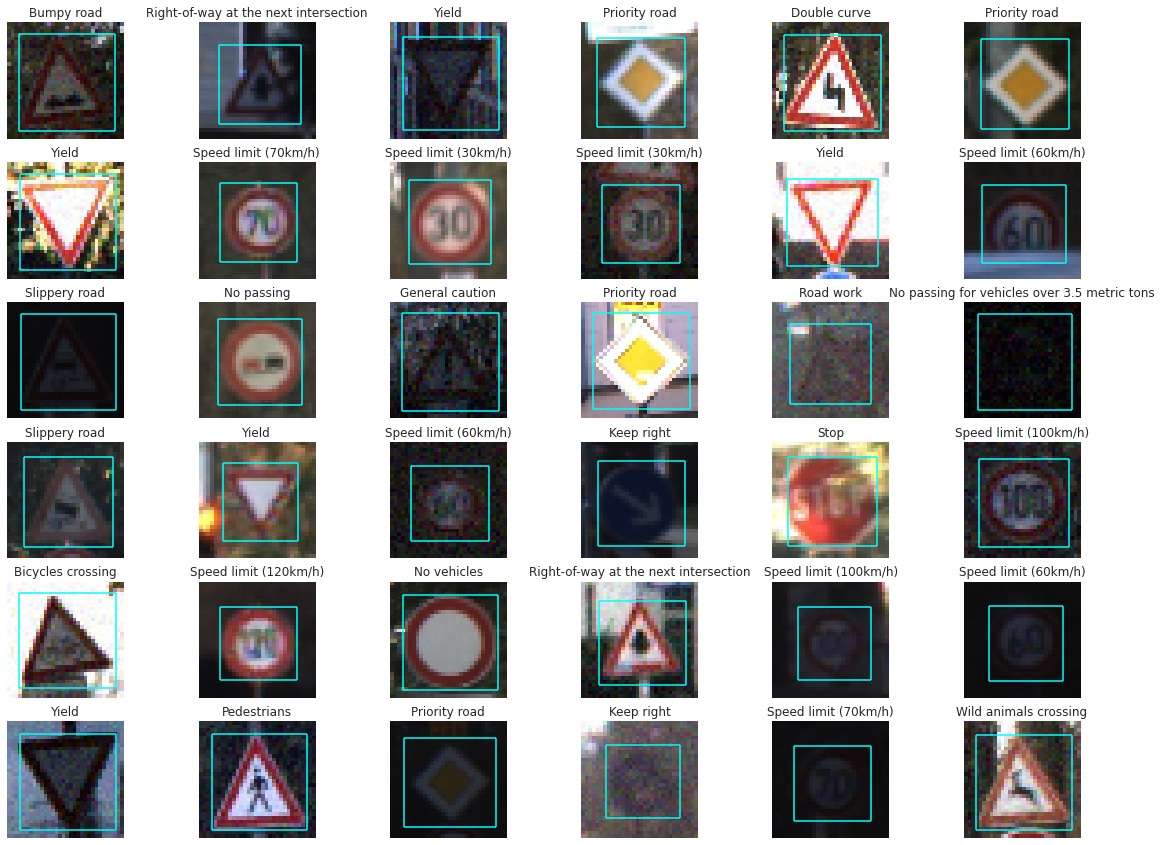

In [ ]:
np.random.seed(22)

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20, 15), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_sign = np.random.randint(0, len(train_dataset))
    img_train, label, bbox = train_dataset[random_sign]
    img_label = classes[label]
    imshow(img_train, img_label, bbox, plt_ax=fig_x)

In [ ]:
torch.manual_seed(0)

model = My_Detector(n_classes=n_classes)
optimizer = torch.optim.Adam(
    (
        {
            'params': chain(model.backbone.parameters(), model.neck.parameters()),
            'lr': 1e-4,
        },
        {
            'params': chain(
                            model.head_classifier.parameters(), 
                            model.head_coords_regressors.parameters()),
        }
     ),
     lr=1e-2
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.67)
criterion = MultiTaskLoss(weight)


epoch 1:
train loss = 9.97086 | valid loss = 2.12642 




epoch 2:
train loss = 2.07438 | valid loss = 1.10384 




epoch 3:
train loss = 1.21500 | valid loss = 0.57733 




epoch 4:
train loss = 0.73262 | valid loss = 0.30503 




epoch 5:
train loss = 0.47276 | valid loss = 0.24840 




epoch 6:
train loss = 0.32961 | valid loss = 0.13189 




epoch 7:
train loss = 0.23973 | valid loss = 0.11567 




epoch 8:
train loss = 0.20196 | valid loss = 0.09661 




epoch 9:
train loss = 0.16127 | valid loss = 0.10120 




epoch 10:
train loss = 0.15344 | valid loss = 0.07243 




epoch 11:
train loss = 0.11180 | valid loss = 0.05465 




epoch 12:
train loss = 0.10099 | valid loss = 0.05742 




epoch 13:
train loss = 0.08322 | valid loss = 0.05818 




epoch 14:
train loss = 0.09081 | valid loss = 0.04565 




epoch 15:
train loss = 0.08388 | valid loss = 0.05455 




epoch 16:
train loss = 0.06084 | valid loss = 0.04083 




epoch 17:
train loss = 0.05552 | valid loss = 0.03833 




epoch 18:
train loss = 0.04789 | valid loss = 0.03660 




epoch 19:
train loss = 0.05348 | valid loss = 0.04019 




epoch 20:
train loss = 0.05988 | valid loss = 0.04448 




epoch 21:
train loss = 0.05154 | valid loss = 0.02418 




epoch 22:
train loss = 0.03971 | valid loss = 0.02424 




epoch 23:
train loss = 0.03781 | valid loss = 0.02511 




epoch 24:
train loss = 0.04013 | valid loss = 0.02282 




epoch 25:
train loss = 0.03212 | valid loss = 0.02410 



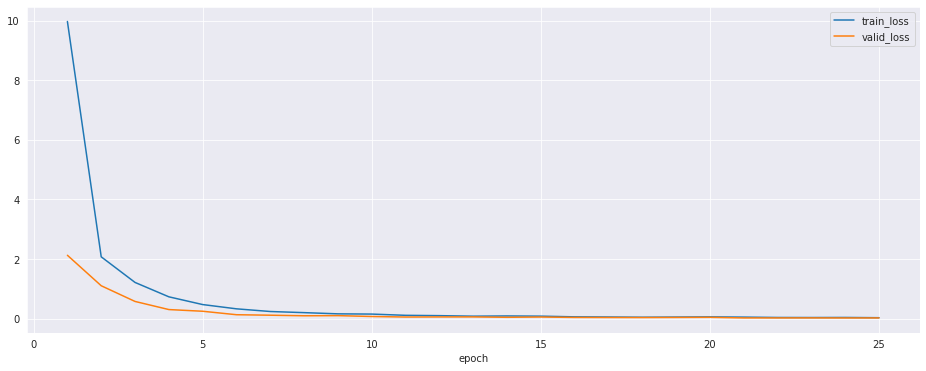

In [ ]:
plot_trainig(*fit(25, model, criterion, optimizer, train_dataloader, val_dataloader, DEVICE, scheduler))

In [ ]:
optimizer = torch.optim.Adam(
    (
        {
            'params': chain(model.backbone.parameters(), model.neck.parameters()),
            'lr': 1e-4,
        },
        {
            'params': chain(
                            model.head_classifier.parameters(), 
                            model.head_coords_regressors.parameters()),
        }
     ),
     lr=1e-2
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.67)


epoch 1:
train loss = 0.24015 | valid loss = 0.05432 




epoch 2:
train loss = 0.18332 | valid loss = 0.04693 




epoch 3:
train loss = 0.17856 | valid loss = 0.04930 




epoch 4:
train loss = 0.09205 | valid loss = 0.03797 




epoch 5:
train loss = 0.07646 | valid loss = 0.03566 




epoch 6:
train loss = 0.14918 | valid loss = 0.10238 




epoch 7:
train loss = 0.08004 | valid loss = 0.03587 




epoch 8:
train loss = 0.04987 | valid loss = 0.03330 




epoch 9:
train loss = 0.05256 | valid loss = 0.02808 




epoch 10:
train loss = 0.10686 | valid loss = 0.03905 




epoch 11:
train loss = 0.05538 | valid loss = 0.03223 




epoch 12:
train loss = 0.05289 | valid loss = 0.02393 




epoch 13:
train loss = 0.04401 | valid loss = 0.01946 




epoch 14:
train loss = 0.03354 | valid loss = 0.01774 




epoch 15:
train loss = 0.03187 | valid loss = 0.02201 




epoch 16:
train loss = 0.03086 | valid loss = 0.01778 




epoch 17:
train loss = 0.04452 | valid loss = 0.02306 




epoch 18:
train loss = 0.03806 | valid loss = 0.01656 




epoch 19:
train loss = 0.02513 | valid loss = 0.01578 




epoch 20:
train loss = 0.02537 | valid loss = 0.01632 




epoch 21:
train loss = 0.02348 | valid loss = 0.01307 




epoch 22:
train loss = 0.02239 | valid loss = 0.01799 




epoch 23:
train loss = 0.02194 | valid loss = 0.01320 




epoch 24:
train loss = 0.02297 | valid loss = 0.01508 




epoch 25:
train loss = 0.02091 | valid loss = 0.01395 



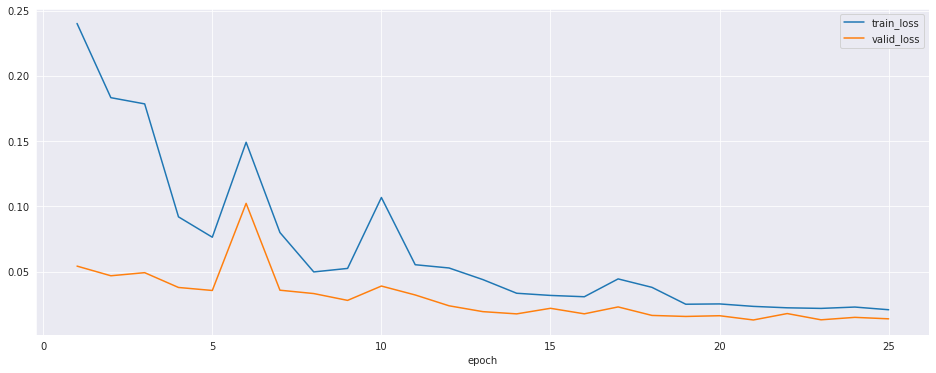

In [ ]:
plot_trainig(*fit(25, model, criterion, optimizer, train_dataloader, val_dataloader, DEVICE, scheduler))

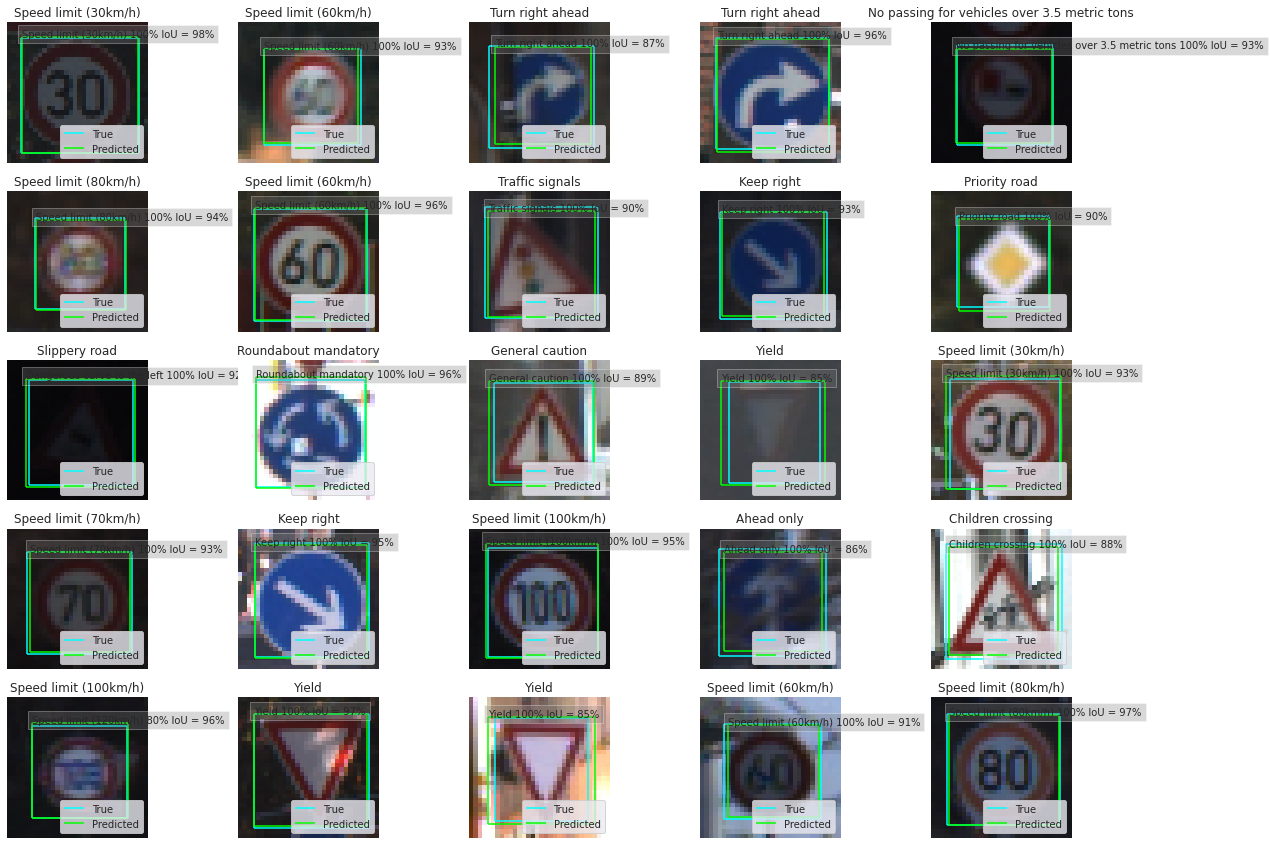

In [ ]:
np.random.seed(65)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_sign = np.random.randint(0, len(test_dataset))
    img_data = test_dataset[random_sign]
    img_dl = DataLoader([img_data])
    img_test, label, bbox = img_data
    img_label = classes[label]
    pred_label = predict(model, img_dl).squeeze()
    pred_bbox = predict_bbox(model, img_dl).squeeze()
    proba = predict_proba(model, img_dl).squeeze()
    pred_img_label = classes[pred_label]
    IoU = calculate_IoU(pred_bbox, bbox)
    pred = [pred_img_label, pred_bbox, proba, IoU]
    imshow(img_test, img_label, bbox, pred, plt_ax=fig_x)

In [ ]:
true_bboxes = test_dataset.bboxes.values
predicted_bboxes = predict_bbox(model, test_dataloader)
mIoU = np.mean([calculate_IoU(true_bbox, predicted_bbox) for true_bbox, predicted_bbox in zip(true_bboxes, predicted_bboxes)])

y_true = test_dataset.labels.values
y_pred = predict(model, test_dataloader)
accuracy = accuracy_score(y_true, y_pred)

print(f'mIoU {mIoU * 100 :.0f}%, classification accuracy {accuracy * 100 :.0f}%')

mIoU 92%, classification accuracy 98%
